In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#https://www.kaggle.com/code/bettycxh06/rri-amplitudes/input
!kaggle datasets download -d bettycxh06/apnea-ecg-database
!kaggle kernels pull bettycxh06/rri-amplitudes

 98% 307M/315M [00:02<00:00, 131MB/s]
100% 315M/315M [00:03<00:00, 105MB/s]
Source code downloaded to /content/rri-amplitudes.ipynb


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
os.listdir(os.getcwd())

['.config',
 'rri-amplitudes.ipynb',
 'kaggle.json',
 'apnea-ecg-database.zip',
 'sample_data']

In [ ]:
!unzip apnea-ecg-database.zip

Archive:  apnea-ecg-database.zip
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/ANNOTATORS  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/RECORDS  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/SHA256SUMS.txt  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.apn  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.dat  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.hea  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.qrs  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01.xws  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.apn  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.hea  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.qrs  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01er.xws  
  inflating: apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0/a01r.apn  

In [ ]:

!pip install biosppy
!pip install wfdb

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import posixpath
import csv
import wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
#base_dir = "../input/apnea-ecg-database/apnea-ecg-database-1.0.0"
base_dir = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
#base_dir = "physionet.org/files/apnea-ecg/1.0.0"



fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()



    answers = {}
    with open(os.path.join("event-2-answers"), "r") as f:
    #    with open(os.path.join(base_dir, "event-2-answers"), "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test)
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!")

Training...
a17: 100%|██████████| 485/485 [49:16<00:00,  6.10s/it]

Testing...
x12: 100%|██████████| 527/527 [49:59<00:00,  5.69s/it]

ok!


In [ ]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#IMPORT LIBRARIES
import pickle
import numpy as np
import tensorflow
import os
from keras.callbacks import LearningRateScheduler,EarlyStopping
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,BatchNormalization
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
import keras
import matplotlib.pyplot as plt
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.models import Model, load_model, save_model
from keras.layers import Input
import pandas as pd

#base_dir = "dataset"
base_dir = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
#base_dir = "physionet.org/files/apnea-ecg/1.0.0"

#------------------------------------------------------------------------------
# DEEP LEARNING MODELS NEED TO VECTORS OR MATRIX WITH SAME SIZE
# R-R INTERVALS DONT HAVE SAME SIZE, SO WE NEED TO INTERPOLATE VECTORS TO GET VECTORS WITH SAME SIZE.
# BASED ON OUR EXPERIENCE INTERPOLATION IN 3 HZ BETTER AND ACCURATE.
ir = 3 # INTERPOLATION RATE(3HZ)
time_range= 60 # 60-s INTERVALS OF ECG SIGNALS
weight=1e-3 #  WEIGHT L2 FOR REGULARIZATION(AVODING OVERFITTING PARAMETER)

#--------ir = 3 # interpolate interval
#--------before = 2
#--------after = 2
#-----------------------------
# NORMALIZATION:
# DEEP LEARNING AND EVEN NEURAL NETWORKS INPUT SHOULD BE NORMALIZED:
# MIN-MAX METHOD APPLIED FOR SCALING:(Array-min(Array))/(max(Array)-min(Array))
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

#-----------------------------
# FIRSTLY WE PRE-PROCESSED OUR DATA IN "apnea-ecg.pkl" FILE
# IN PRE-PROCESSING SECTION WE EXTRACT R-R INTERVALS AND R-PEAK AMPLITUDES
# IN THIS PART WE LOAD THIS DATA AND INTERPOLATE AND CONCATE FOR FEEDING TO NETWORKS
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)
#-----------------
    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    #groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (amp_tm, amp_signal) = o_train[i]
      # Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        amp_interp_signal = splev(tm, splrep(amp_tm, scaler(amp_signal), k=3), ext=1)
        x_train.append([rri_interp_signal, amp_interp_signal])
    x_train = np.array(x_train, dtype="float32")

    x_train = np.expand_dims(x_train,1)
    x_train=np.array(x_train, dtype="float32").transpose((0,3,1,2)) # convert to numpy format

    #x_train_final=np.array(x_train, dtype="float32").transpose((0,3,1,2))
    #x_train=np.array(x_train, dtype="float32").transpose((0,3,1,2))

    #return x_train_final, y_train
    return x_train, y_train



In [ ]:
  #print(x_train.shape, y_train.shape)

train num: 16709
test num: 16945
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 894, 1, 96)        1440      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 298, 1, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 298, 1, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 294, 1, 256)       123136    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 98, 1, 256)       0         
 g2D)                                                            
                     

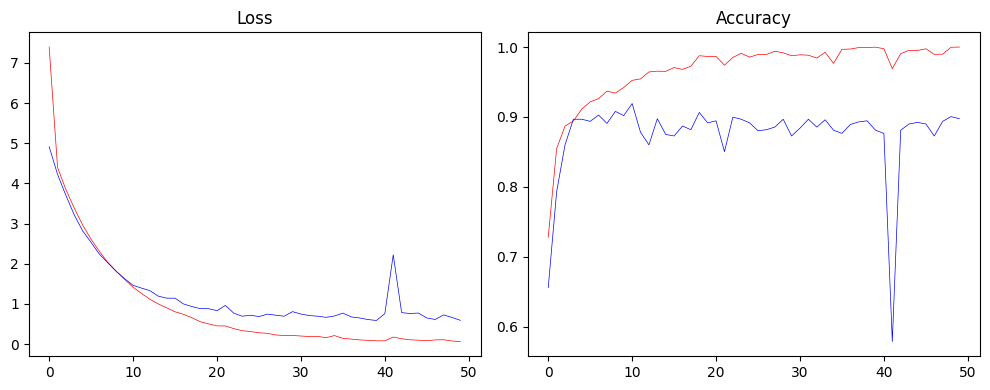

In [ ]:
# CREAT DEEP LEARNING MODEL
def create_model(weight=1e-3):

    model= Sequential()
    model.add(Conv2D(96, kernel_size=(7,1), strides=(1,1), padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight),input_shape=(900,1,2)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(5,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=(3,1), strides=(1,1), padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(1024, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(3,1),strides=(2,1)))
    model.add(Flatten())
    model.add(Dense(418, activation="relu"))

    model.add(Dense(2, activation="softmax"))

    return model

#------------------------------------------------------------------------------
# Define learning rate schedule for preventing overfitting in deep learning methods:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr
#------------------------------------------------------------------------------
def plot(history):
	  #"""Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()
#------------------------------------------------------------------------------
# Compile and evaluate model:
if __name__ == "__main__":
    # loading Data:
    x_train, y_train = load_data()
    # we have labels(Y) in a binary way 0 for normal and 1 for apnea patients
    # we want to classify data into 2-class so we changed y in a categorical way:
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    # we used k-fold cross-validation for more reliable experiments:
    kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=7)
    cvscores = []
    ACC=[]
    SN=[]
    SP=[]
    F2=[]


    print("train num:", len(y_train))
    print("test num:", len(y_test))

    # separate train& test and then compile model
    for train, test in kfold.split(x_train, y_train.argmax(1)):
     model = create_model()
     model.summary()


    from keras.utils import plot_model
    plot_model(model, "model.png") # Plot model

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
     # define callback for early stopping:
    lr_scheduler = LearningRateScheduler(lr_schedule)
    callback1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     #10% of Data used for validation:
    X1,x_val,Y1,y_val=train_test_split(x_train[train],y_train[train],test_size=0.10)

    history = model.fit(X1, Y1, batch_size=128, epochs=100, validation_data=(x_val, y_val),
                        callbacks=[callback1,lr_scheduler])

    model.save(os.path.join("model.ZFNet.h5"))

    loss, accuracy = model.evaluate(x_train[test], y_train[test])


    print("Test loss: ", loss)
    print("Accuracy: ", accuracy)

    # save prediction score
    y_score = model.predict(x_train[test])



    y_predict= np.argmax(y_score, axis=-1)
    y_training = np.argmax(y_train[test], axis=-1)

    plot(history.history)

    # Confusion matrix:
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    C = confusion_matrix(y_training, y_predict, labels=(1, 0))
    TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
    acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
    f2=f1_score(y_training, y_predict)

    ACC.append(acc * 100)
    SN.append(sn * 100)
    SP.append(sp * 100)
    F2.append(f2 * 100)

    print(ACC)
    print(SN)
    print(SP)
    print(F2)